In [52]:
%load_ext autoreload
%autoreload 2

from natto.process.kNearestNeighbours import timeSliceNearestNeighbor, timeSliceNearestNeighborOG
from natto import input, process
from natto.out import draw
from natto.process import cluster, util
from natto.process.cluster import k2means, hungutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import importlib
from umap.umap_ import UMAP
from pynndescent import NNDescent
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score as ARI
from tslearn.clustering import TimeSeriesKMeans
import anndata as ad
from anndata import AnnData
import scanpy as sc
from scanpy.pp import pca as PCA
from scanpy.pp import neighbors, subsample, scale, calculate_qc_metrics, combat
import importlib

In [3]:
def preprocess(annDataList, 
               selector='natto', 
               selectslice='all',
               donormalize = True,
               make_even=True,
               joint_space=True,
               selectgenes=800,
               min_counts=3,
               pca=20,
               umaps=[10,2]):
    print("Preprocessing")
    Data  = process.Data().fit(annDataList, 
                               selector=selector, 
                               selectslice=selectslice,
                               visual_ftsel=False, 
                               joint_space=joint_space,
                               donormalize=donormalize,
                               normTogether=False,
                               make_even=make_even,
                               plotPCA=True,
                               scale=False,
                               sortfield=1,
                               selectgenes=selectgenes, #default is 800
                               min_counts=min_counts,
                               pca=pca, #default is 20  
                               umaps=umaps
                              )

    return Data   

In [54]:
### Load Data
t0 = time.time()
subsampleNum = 1000 # None or int
datasets = 'rawMouseCortex' # Can be 'sim', 'simLarge', MouseCortex', 'rawMouseCortex', Waterston', 'pancreas', 'pancreasv2'

loadedData = []
loadedLabels = []

print("Loading Data")
if datasets == 'sim':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/sim_data/"
    for i in range(5):
        loadedLabels.append(pd.read_csv(f'{inputDirectory}time{i}_labels.csv', sep=',', header=None)[0].values.astype(int))
        loadedData.append(ad.read_csv(f'{inputDirectory}time{i}.csv'))
    Labels=loadedLabels
        
if datasets == 'simLarge':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/sim_data/"
    for i in range(5):
        loadedData.append(pd.read_csv(f'{inputDirectory}wLargeCluster_time{i}.csv', sep=',', header=None).values)
        loadedLabels.append(pd.read_csv(f'{inputDirectory}wLargeCluster_time{i}_labels.csv', sep=',', header=None)[0].values.astype(int))
    Labels=[l for l in loadedLabels]
                
elif datasets == 'rawMouseCortex':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/MouseCortexData/"
    batch = 2
    for index, item in enumerate(['e11', 'e13', 'e15', 'e17']):
        print(index)
        batch=None
        if index==2:
            batch=2
        data = input.loadCortex(subsample=subsampleNum, pathprefix=inputDirectory + 'raw' + item, batch=batch)
        loadedData.append(data)

elif datasets == "MouseCerebellum":
    EorP = 'E'
    
    inputDirectory = "/Volumes/Expansion/Tempora/MouseCerebellumData/"
    timeNames=[]
    if 'E' in EorP:
        timeNames += ['E10', 'E12', 'E14', 'E16', 'E18']
    if 'P' in EorP:
        timeNames += ['P0', 'P5', 'P7', 'P14']

    for index, item in enumerate(timeNames):
        print(index)
        data=input.loadCerebellum(subsample=subsampleNum, pathprefix=inputDirectory + item)
        loadedData.append(data)

elif datasets == 'immune':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/immune_stim/"
    for index, dataName in enumerate(['8', '9']):
        print(index)
        data = input.loadpbmc(path=inputDirectory+dataName, subsample=subsampleNum)
        loadedData.append(data)

elif datasets == 'Waterston':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/GSE126954_data/"
    for index, item in enumerate(['Waterston_300', 'Waterston_400', 'Waterston_500_1']):
        print(index)
        anndata = input.loadGSM(f'{inputDirectory}{item}/', subsample=subsampleNum, cellLabels=True,)
        anndata = anndata[~np.isnan(anndata.obs['labels'].to_numpy())]
        loadedData.append(anndata)

elif datasets == 'pancreas':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/GSE101099_data/GSM269915"
    for index, item in enumerate(['6_E12_B2', '5_E14_B2', '7_E17_B2']):
        print(index)
        anndata = input.loadGSM(f'{inputDirectory}{item}/', subsample=subsampleNum, cellLabels=True, labelFile='theirLabels.csv')
        nonBloodGenesList = [name for name in anndata.var_names if (not name.startswith('Hb') and not name.startswith('Ft'))]
        anndata= anndata[:, nonBloodGenesList]
        loadedData.append(anndata)

    
elif datasets == 'pancreasv2':
    inputDirectory = "/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/GSE101099_data/GSM314091"
    for index, item in enumerate(['5_E12_v2', '6_E14_v2', '7_E17_1_v2', '8_E17_2_v2']):
        print(index)
        anndata = input.loadGSM(f'{inputDirectory}{item}/', subsample=subsampleNum, cellLabels=True,)
        loadedData.append(anndata)
        
for data in loadedData:
    print(len(data))
    print(data.shape)
    
print("Files Loaded")
t1 = time.time()
print(f"Time Elapsed: {(t1-t0)//1}s")

Loading Data
0
1
2
3
[array([5, 5, 7, 6, 4, 7, 5, 4, 5, 3, 3, 6, 5, 3, 7, 1, 4, 6, 5, 4, 3, 3,
       3, 3, 3, 3, 5, 2, 5, 4, 4, 3, 3, 3, 3, 6, 1, 3, 3, 3, 3, 3, 2, 3,
       5, 3, 5, 4, 3, 2, 4, 1, 7, 3, 6, 3, 3, 1, 4, 1, 3, 4, 6, 3, 6, 4,
       4, 3, 6, 5, 7, 3, 3, 3, 3, 3, 3, 4, 5, 5, 1, 5, 3, 3, 1, 1, 3, 5,
       3, 1, 3, 2, 3, 6, 2, 3, 6, 5, 4, 3, 1, 3, 6, 3, 5, 1, 3, 6, 2, 3,
       5, 3, 3, 3, 3, 4, 3, 4, 3, 5, 3, 5, 3, 3, 3, 3, 3, 1, 4, 5, 3, 3,
       1, 3, 6, 5, 3, 3, 5, 3, 4, 3, 3, 5, 5, 1, 4, 3, 3, 5, 3, 3, 6, 4,
       4, 3, 3, 6, 5, 3, 5, 3, 6, 5, 5, 3, 4, 3, 1, 3, 3, 6, 6, 3, 3, 3,
       7, 5, 6, 4, 5, 2, 2, 5, 5, 1, 4, 7, 3, 4, 5, 3, 5, 6, 4, 5, 5, 3,
       3, 6, 6, 3, 3, 3, 6, 1, 6, 3, 2, 4, 3, 7, 4, 4, 3, 3, 3, 5, 5, 3,
       4, 5, 4, 3, 1, 5, 3, 5, 5, 4, 1, 3, 5, 5, 3, 3, 3, 3, 2, 4, 3, 3,
       5, 3, 5, 3, 4, 3, 3, 5, 6, 4, 3, 1, 3, 7, 3, 5, 3, 5, 3, 3, 3, 1,
       3, 2, 3, 5, 3, 3, 6, 3, 3, 5, 3, 3, 1, 3, 5, 3, 1, 3, 3, 3, 5, 7,
       3, 5, 3, 3, 4, 1, 3, 1

Preprocessing Data
Preprocessing


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but no

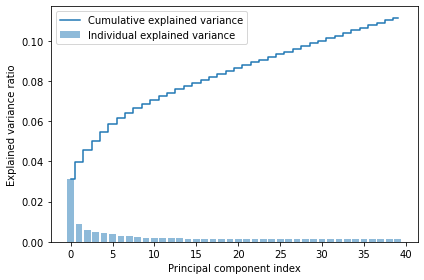

Data Preprocessed
Time Elapsed: 123.0s


In [59]:
### Preprocess Data
t0 = time.time()
doCombat=False
Data=[]

print("Preprocessing Data")
if datasets == 'sim':
    Data = process.Data()
    Data.data = loadedData
    
elif datasets == 'simLarge':
    Data = process.Data()
    Data.data = loadedData

elif datasets == 'rawMouseCortex':
    Data = preprocess(loadedData, joint_space=True, 
                      donormalize=False, make_even=False, selectgenes=800, selector='seurat_v3', pca=40)
    Labels = [data.obs['labels'].to_numpy() for data in Data.data]
        
elif datasets == 'MouseCerebellum':
    Data = preprocess(loadedData, joint_space=True, 
                      donormalize=False, make_even=False, selectgenes=4000, selector='natto', pca=40, umaps=[])
    Labels = [data.obs['labels'].to_numpy() for data in Data.data]

elif datasets == 'immune':
    Data = preprocess(loadedData, joint_space=True, 
                      donormalize=True, make_even=False, selectgenes=2000, selector='natto', pca=40, umaps=[])
    
elif datasets == 'Waterston':
    Data = preprocess(loadedData, selector='seurat_v3', selectgenes=800, pca= 40, min_counts=10, donormalize=True)
    Labels = [data.obs['labels'].to_numpy() for data in Data.data]

elif datasets == 'pancreas':
    Data = preprocess(loadedData, selectslice='all', selectgenes=800, pca= 40, min_counts=10, selector='seurat_v3')
    Labels = [data.obs['labels'].to_numpy() for data in Data.data]
    
elif datasets == 'pancreasv2':
    Data = preprocess(loadedData)
    Labels = [data.obs['labels'].to_numpy() for data in Data.data]
    Data = [data.to_df().to_numpy() for data in Data.data]
    

if doCombat:
    Data = process.batchCorrect(Data)

print("Data Preprocessed")
t1 = time.time()
print(f"Time Elapsed: {(t1-t0)//1}s")

In [22]:
from sklearn.metrics.pairwise import cosine_similarity as cos
from sklearn.metrics import jaccard_score as js
from ubergauss import tools
from seaborn import heatmap

simScore = 'Jaccard' # 'Jaccard' or "Cosine'"

def cosine(genescores, i,j, numgenes = 0):
    scr1 = genescores[i]
    scr2 = genescores[j]
    if numgenes:
        mask = scr1+scr2
        mask = tools.binarize(mask,numgenes).astype(bool)
        scr1 = scr1[mask]
        scr2 = scr2[mask]
    return cos([scr1],[scr2]).item()

def jaccard(genescores, i, j, ngenes= False):
    # intersect/union
    scr1 = genescores[i]
    scr2 = genescores[j]
    asd = np.array([ booltopx(s,ngenes)  for s in [scr1,scr2]])
    union = np.sum(np.any(asd, axis=0))
    intersect = np.sum(np.sum(asd, axis=0) ==2) # np.sum(np.logicaland(asd[0] , asd[1])
    return intersect/union

def booltopx(ar,num):
    srt = np.sort(ar)
    return np.array(ar) >=srt[-num]

def score(m):
    x=[]
    for i in range(m.shape[1]-1):
        p=np.argsort(-m[i, i+1:])
        t=np.arange(len(p))
        x += list(p==t)
        
        p=np.argsort(-m[i, i+1:])
        t=np.arange(len(p))
        x += list(p==t)
    return sum(x)/len(x)

def score2(m):
    x=0
    for i in range(m.shape[1]-2):
        for j in range(i+2, m.shape[0]):
            if m[i,j]>m[i-1,j] and m[i,j]>m[i,j-1]:
                x += 1
    return x

def makeAff(Data, method, numgenes=400):
    l = len(Data.data)
    res = np.zeros([l,l])
    for i in range(l):
        for j in range(l):
            if i!=j:
                if simScore=='Cosine':
                    res[i,j] = cosine(Data.genescores, i, j, numgenes=numgenes)
                elif simScore == 'Jaccard':
                    res[i,j] = jaccard(Data.genescores, i, j, ngenes=numgenes)
    return res
    
def drawMatrix(res):
    fig=heatmap(res)
    plt.tight_layout()
    #plt.savefig('MouseCerebellumHeatmap.png')
    plt.show()
    
do=False
if do:
    print("Cosine")
    cosMatrices=[]
    for i, ngenes in enumerate(range(200, 1500, 50)):
        res = makeAff(Data, 'Cosine', numgenes=ngenes)
        cosMatrices.append(res)
        print(f"With Numgenes={ngenes} (index:{i}), Score: {score2(res)}")

    print("\nJaccard")
    jacMatrices=[]
    for i, ngenes in enumerate(range(500, 4000, 50)):
        res = makeAff(Data, 'Jaccard', numgenes=ngenes)
        jacMatrices.append(res)
        print(f"With Numgenes={ngenes} (index:{i}), Score: {score2(res)}")

"\nfig=heatmap(res)\nplt.tight_layout()\n#plt.savefig('MouseCerebellumHeatmap.png')\nplt.show()\n"

(9572,)
(9572,)


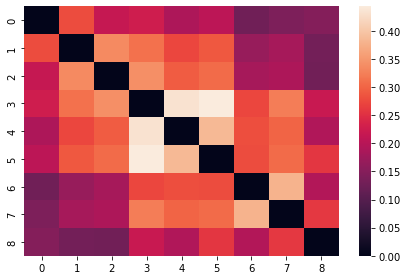

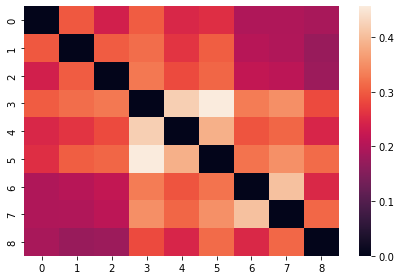

In [31]:
np.fill_diagonal(jacMatrices[40], .7)
print(Data.genescores[0].shape)
print(Data.genescores[1].shape)
drawMatrix(cosMatrices[3])
drawMatrix(jacMatrices[2])

In [60]:
### Calculate NNGraph
from natto.process.kNearestNeighbours import sklearnNN, hungarian, hungarianAll, sklearnNNOG, hungarianOG, hungarianAllOG
whichProjection = 'PCA'
multiscale=False
n_components=5

kFromNeighbors=2
kFromSame=10
intraSliceNeighbors=sklearnNN #['sklearnNN', 'hungarian', 'hungarianAll']
interSliceNeighbors=hungarian #['sklearnNN', 'hungarian', 'hungarianAll']
distanceMetric='normMeans'
distCoeff=1 #Default 1
farPenalty=1
sortVar=True
    
    
t0 = time.time()

###
if whichProjection=='PCA' and ('sim' not in datasets) and ('simLarge' not in datasets):
    print("Using PCA")
    nnData = Data.projections[1]
elif whichProjection=='umap':
    print("Using Umap")
    nnData = Data.d10
else:
    nnData = [data.to_df().to_numpy() for data in Data.data]
        

print("Computing Nearest Neighbors")
(precomputedKNNIndices, precomputedKNNDistances) = timeSliceNearestNeighbor(nnData,
                                                                        kFromNeighbors=kFromNeighbors, 
                                                                        kFromSame=kFromSame,
                                                                        intraSliceNeighbors=intraSliceNeighbors,
                                                                        interSliceNeighbors=interSliceNeighbors,
                                                                        distanceMetric=distanceMetric,
                                                                        distCoeff=distCoeff,
                                                                        farPenalty=farPenalty,
                                                                        sort=sortVar)
    
t1 = time.time()
print(f"Time Elapsed: {(t1-t0)//60}m")

Using PCA
Computing Nearest Neighbors


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Dataset 0 Complete


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Dataset 1 Complete


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/natto/natto/process/kNearestNeighbours.py:174: RuntimeWarning: invalid value encountered in true_divide
  meanFactor=np.array( [np.divide( np.mean(intraDists[:,1:], axis=1), (d.sum(axis=1).getA1()/d.getnnz(axis=1) ) )


Dataset 2 Complete


/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/JackBrons/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Dataset 3 Complete
Time Elapsed: 0.0m


In [61]:
# Calculate NNDescent object, Umap, and Transform Data
t0 = time.time()

usePrecomputed = True

print(np.vstack(nnData))
print(np.vstack(nnData).shape)

if usePrecomputed:
    print(precomputedKNNIndices.shape)
    print(precomputedKNNDistances.shape)
    print("Computing NNDescent Object")

    pyNNDobject = NNDescent(np.vstack(nnData), metric='euclidean', random_state=1337)
    pyNNDobject._neighbor_graph = (precomputedKNNIndices.copy(), precomputedKNNDistances.copy())
    precomputedKNN = (precomputedKNNIndices, precomputedKNNDistances, pyNNDobject)
    n_neighbors = precomputedKNNIndices.shape[1]
else:
    precomputedKNN = (None, None, None)
    n_neighbors = 15

print("Beginning UMAP Projection")
mymap = UMAP(n_components=2, #Dimensions to reduce to
    n_neighbors=n_neighbors,
    random_state=1337,
    metric='euclidean',
    precomputed_knn=precomputedKNN,
    force_approximation_algorithm=True)
mymap.fit(np.vstack(nnData))

print("Transforming Data")
transformedData = [mymap.transform(x) for x in nnData]


t1 = time.time()
print(f"Time Elapsed: {(t1-t0)//60}m")

[[ 11.536874    -1.7994949    3.7055066  ...   1.4690157   -0.78637254
   -0.36652344]
 [ 10.877837    -1.0747557    3.1416569  ...   0.53992635  -0.5422909
    0.20053628]
 [  6.548759     2.8070333    9.600238   ...   0.07585488  -0.47012174
    0.83446515]
 ...
 [ 11.501959    -5.787871   -11.968062   ...  -2.1112156   -3.711013
   -2.3043313 ]
 [ -3.9763       0.5359254    0.2179727  ...  -1.0202743    1.8650246
   -1.5275868 ]
 [ -4.5682626   -3.5500057   -2.420505   ...   2.086983     2.7007146
    0.51213586]]
(3863, 40)
(3863, 14)
(3863, 14)
Computing NNDescent Object
Beginning UMAP Projection
Transforming Data
Time Elapsed: 0.0m


Preparing Real Labels
(3863,)
Predicting Gaussian Labels
ARI:0 0.4873357284635873
ARI:1 0.4040060501481547
ARI:2 0.5327474272575224
ARI:3 0.6157347142385221
Average ARI = 0.5099559800269466
Overall ARI: 0.4443547168695393
Calculating Louvain Labels
ARI:0 0.4916187595331286
ARI:1 0.5655946900588398
ARI:2 0.5700589512472886
ARI:3 0.4554201166282682
Average ARI = 0.5206731293668813
Overall ARI: 0.48003338412151797
Length of Labels: 12
Length of Data to Draw: 12


(3, 4)
[1000, 1000, 1000, 863, 1000, 1000, 1000, 863, 1000, 1000, 1000, 863]


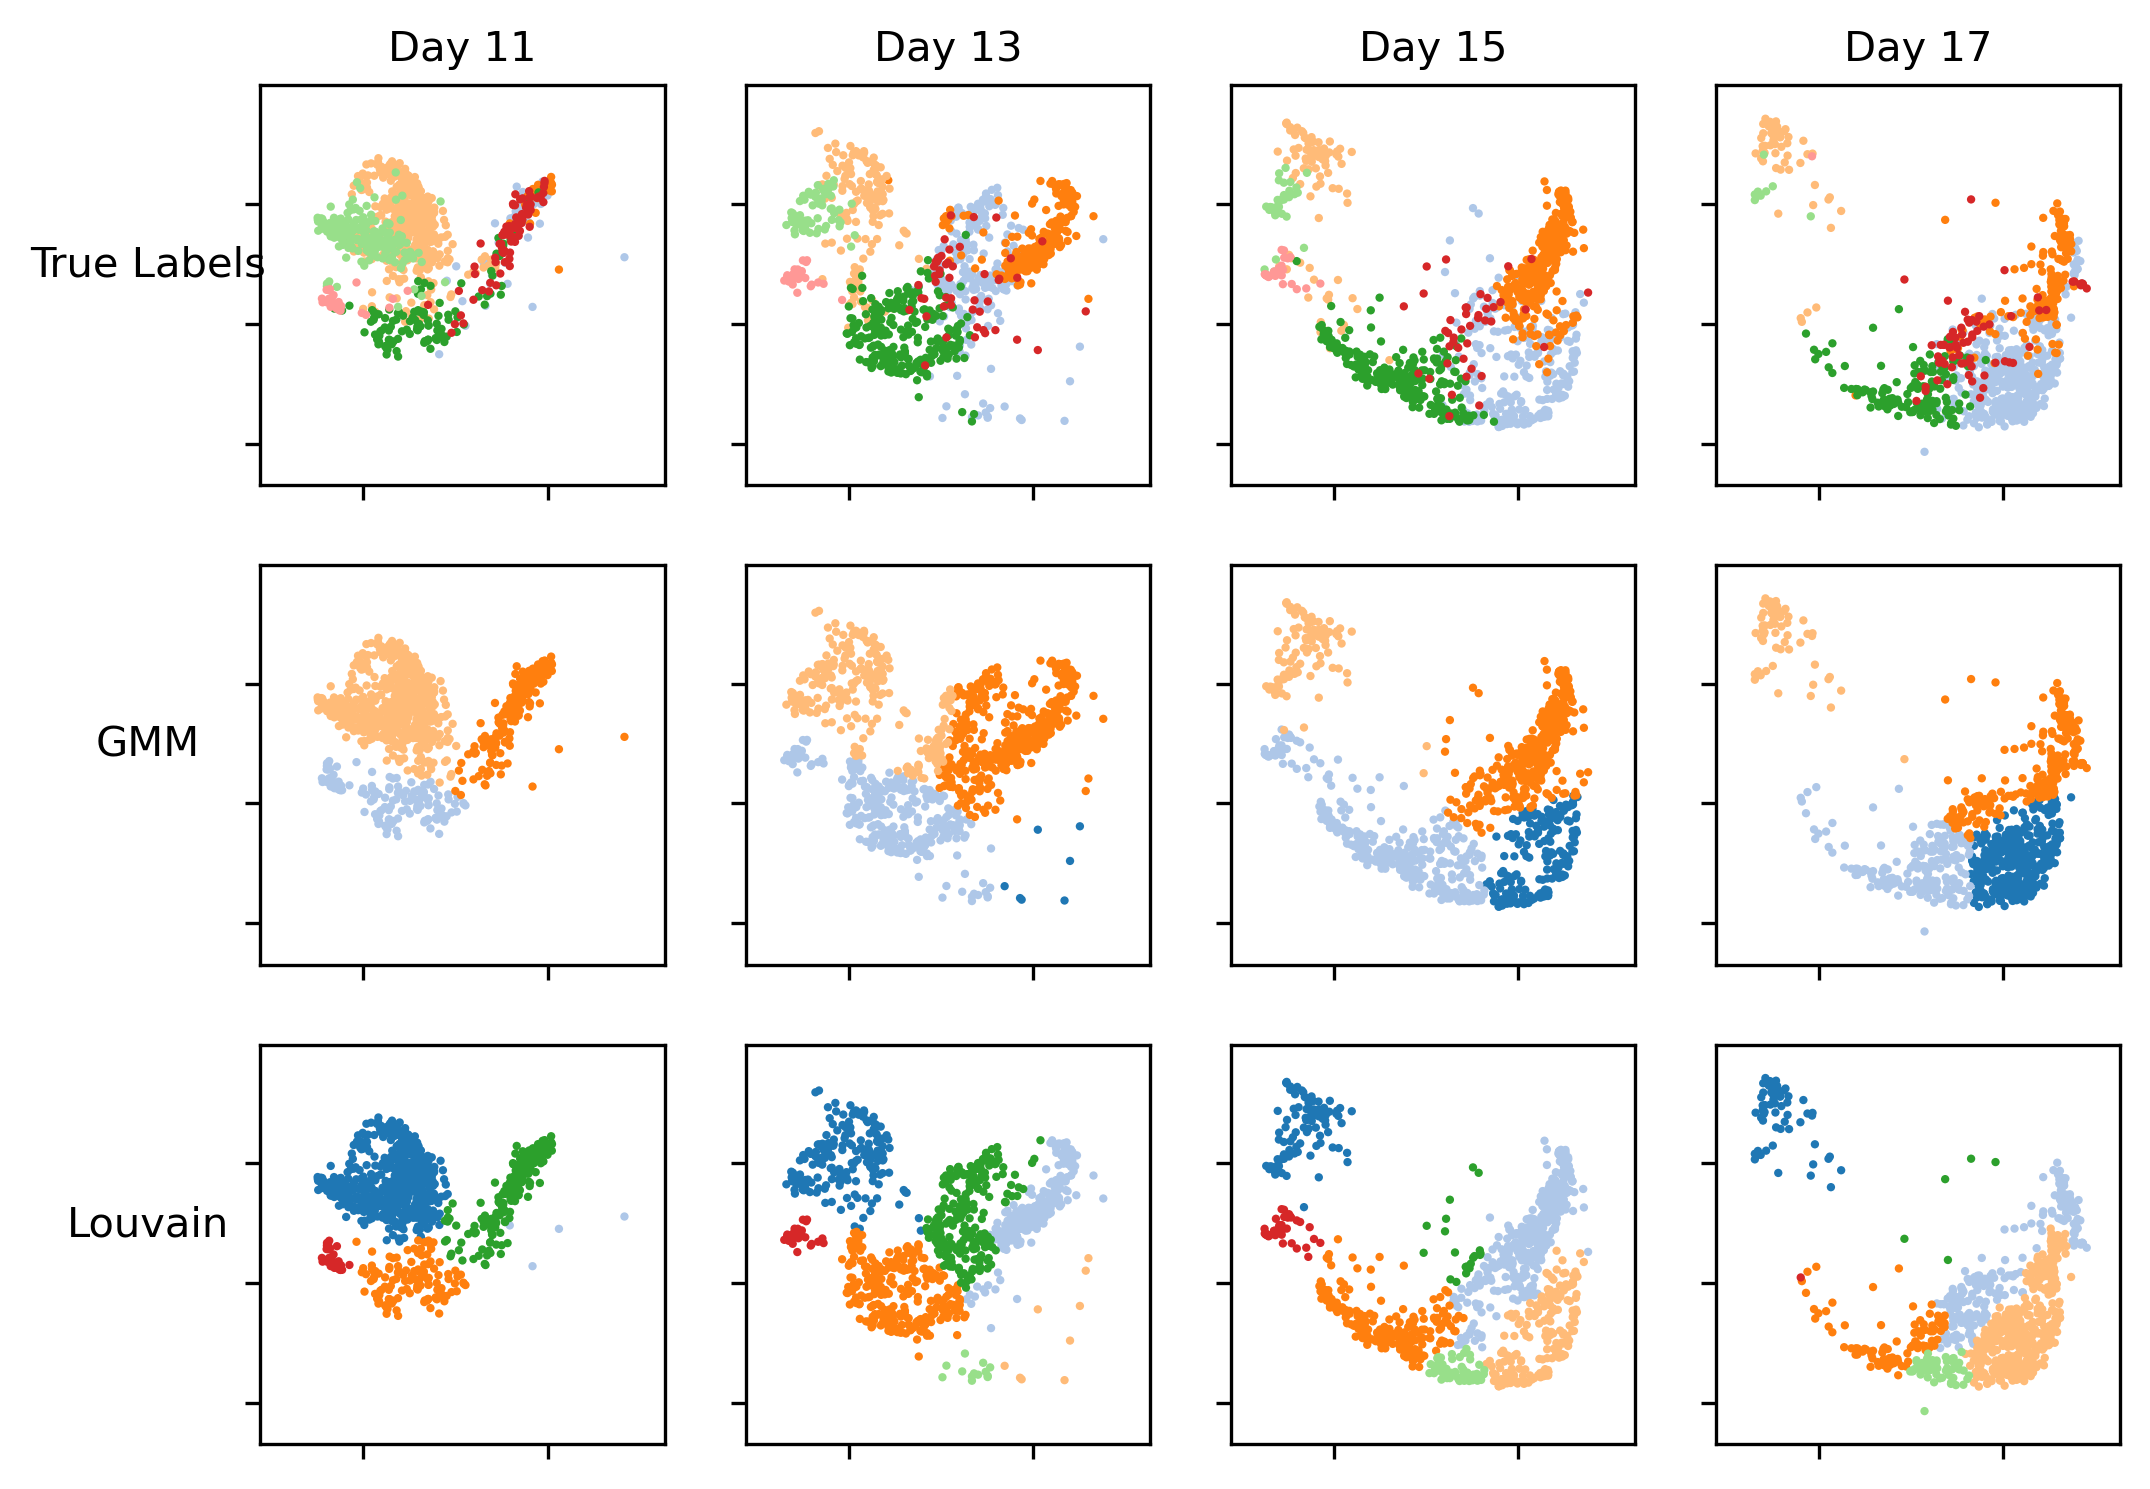

{'GMM': [0.4443547168695393, 0.5099559800269466, 0.4873357284635873, 0.4040060501481547, 0.5327474272575224, 0.6157347142385221], 'Louvain': [0.48003338412151797, 0.5206731293668813, 0.4916187595331286, 0.5655946900588398, 0.5700589512472886, 0.4554201166282682]}
         Together      Mean    Day 11    Day 13    Day 15    Day 17
GMM      0.444355  0.509956  0.487336  0.404006  0.532747  0.615735
Louvain  0.480033  0.520673  0.491619  0.565595  0.570059  0.455420
Total time elapsed: 2.0s


In [110]:
def ARICalc(methodName, ARIDict, tempLabels, predLabels):
    ARIDict[methodName] = []
    ARIDict[methodName].append(ARI([y for labels in tempLabels for y in labels], [item for sublist in predLabels for item in sublist]))
    ARIDict[methodName].append(np.mean([ARI(tempLabels[i], predLabels[i]) for i in range(len(tempLabels))]))

    for index, l in enumerate(tempLabels):
        print(f"ARI:{index} {ARI(tempLabels[index], predLabels[index])}")
        ARITableDict[methodName].append(ARI(tempLabels[index], predLabels[index]))
    print(f"Average ARI = {np.mean([ARI(tempLabels[i], predLabels[i]) for i in range(len(tempLabels))])}")
    print(f"Overall ARI: {ARI([y for labels in tempLabels for y in labels], [item for sublist in predLabels for item in sublist])}")

    
t0 = time.time()
ARITableDict = {}
doARI = True
drawData = []
drawLabels = []
method = ["True Labels", "GMM", 'Louvain'] # 'True Labels', GMM', 'Louvain', 'leiden', 'DBSCAN', 'HDBSCAN', 'natto'
#method = ['True Labels']
make_even=False


### Predict the labels of our transformed data
transformedDataStack = np.vstack(transformedData)
tempData = [x.copy() for x in transformedData]
if Labels is not None:
    tempLabels = [y.copy() for y in Labels]

### Performs function to get Labels
if 'True Labels' in method and Labels is not None:
    print("Preparing Real Labels")
    for index in range(len(tempLabels)):
        tempLabels[index] = [int(x) for x in tempLabels[index]]
        tempData[index] = AnnData(tempData[index])
        tempData[index].obs['labels'] = tempLabels[index]

    if make_even:
        counts = [e.shape[0] for e in tempData]
        smallest = min(counts)
        for i,a in enumerate(tempData):
            if a.shape[0] > smallest:
                subsample(tempData[i],
                                fraction=None,
                                n_obs=smallest,
                                random_state=0,
                                copy=False)
            print(a.shape)

    stackedLabels = np.hstack([x.obs['labels'] for x in tempData]).flatten()
    print(stackedLabels.shape)
    tempLabels = [list(x.obs['labels']) for x in tempData]
    tempData = [x.to_df().to_numpy() for x in tempData]

    drawLabels += tempLabels


### Gets correct indices for each set of labels
### Clustering methods returned stacked labels, needed for unstack
sumToAdd = 0
shapes = [x.shape[0] for x in tempData]
for index in range(len(shapes)):
    shapes[index] += sumToAdd
    sumToAdd = shapes[index]
dataIndices = [0] + shapes
#######################################

if 'GMM' in method:
    print("Predicting Gaussian Labels")
    n_components=4
    labels2D = GaussianMixture(n_components=n_components, covariance_type='full', random_state=1337).fit_predict(np.vstack(tempData))
    labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]

    if Labels is not None and doARI:
        ARICalc('GMM', ARITableDict, tempLabels, labels2D)
    drawLabels += labels2D

if 'Louvain' in method:
    from scanpy.tl import louvain
    print("Calculating Louvain Labels")
    transformedAnnData = AnnData(np.vstack(tempData))
    neighbors(transformedAnnData)
    louvain(transformedAnnData, resolution=0.1, random_state=1337)
    labels2D = [int(x) for x in transformedAnnData.obs['louvain']]
    labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
    if Labels is not None and doARI:
        ARICalc('Louvain', ARITableDict, tempLabels, labels2D)

    drawLabels += labels2D

if 'leiden' in method:
    from scanpy.tl import leiden
    print("Calculating Leiden Labels")
    transformedAnnData = AnnData(np.vstack(tempData))
    neighbors(transformedAnnData)
    leiden(transformedAnnData, resolution=0.12, random_state=1337)
    labels2D = [int(x) for x in transformedAnnData.obs['leiden']]
    labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
    if Labels is not None and doARI:
        ARICalc('leiden', ARITableDict, tempLabels, labels2D)
    drawLabels += labels2D

if 'DBSCAN'in method:
    from sklearn.cluster import DBSCAN
    print("Performing DBSCAN Clustering")
    labels2D = list(DBSCAN(eps=0.15, min_samples=10).fit(np.vstack(tempData)).labels_)
    labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]

    if Labels is not None and doARI:
        ARICalc('DBSCAN', ARITableDict, tempLabels, labels2D)
    drawLabels += labels2D       

if 'HDBSCAN' in method:
    from hdbscan import HDBSCAN
    print("Performing HDBSCAN Clustering")
    labels2D = list(HDBSCAN(min_cluster_size=25, min_samples=25, alpha=1.8).fit(np.vstack(tempData)).labels_)
    labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
    drawLabels += labels2D

if 'KMeans' in method:
    from sklearn.cluster import KMeans
    print("Performing KMeans Clustering")
    labels2D = list(KMeans(n_clusters=18).fit(np.vstack(tempData)).labels_)
    labels2D = [labels2D[dataIndices[k]:dataIndices[k+1]] for k in range(0, len(dataIndices)-1)]
    if Labels is not None and doARI:
        ARICalc('KMeans', ARITableDict, tempLabels, labels2D)
    drawLabels += labels2D

if 'natto' in method:
    print("Performing Natto Clustering")
    labels2D = cluster.gmm_1(tempData[0])
    print([d.shape for d in tempData])
    labels2D, e, labels, probas = k2means.multitunnelclust((tempData), labels2D, method='full')
    labels2D[e] = -1

    if Labels is not None and doARI:
        ARICalc('natto', ARITableDict, tempLabels, labels)
    drawLabels += labels

drawData = tempData * len(method)
print(f"Length of Labels: {len(drawLabels)}")
print(f"Length of Data to Draw: {len(drawData)}")


dim = (len(drawLabels)//len(Data.data), len(Data.data))
print("\n")
print(dim)
print([np.asarray(x).shape[0] for x in drawData])
makeTitles = True
ytitles= ['\n' + m for m in method]
if makeTitles==False:
    xtitles, ytitles = None, None
elif datasets=='rawMouseCortex':
    xtitles = ['Day 11', 'Day 13', 'Day 15', 'Day 17']
elif datasets == 'MouseCerebellum':
    xtitles=[]
    if 'E' in EorP:
        xtitles += ['E10','E12','E14','E16','E18']
    if 'P' in EorP:
        xtitles += ['P0','P5','P7','P14']
elif datasets == 'sim' or datasets=='simLarge':
    xtitles = ['Time 0', 'Time 1','Time 2', 'Time 3', 'Time 4']
#xtitles = [f'time {t}' for t in range(dim[1])]
#ytitles = ['\nTrue\nLabels']

draw.auto_tiny(drawData, drawLabels, wrap='test', dim=dim, same_limit=True, xtitles=xtitles, ytitles=ytitles, legend=False, save=False, save_name=f'MouseCerebellum_E_Novel.png')
t1 = time.time()

if doARI:
    print(ARITableDict)
    print(pd.DataFrame(ARITableDict.values(), index=ARITableDict.keys(), columns = ['Together', 'Mean']+xtitles))
print(f"Total time elapsed: {(t1-t0)//1}s")


In [69]:
###### Hyperparameter Search
### Find Max ARI
method = 'gauss'

if method=='gauss':
    values = range(1,30)
    scores=[]
    for n in values:
        labels2D = GaussianMixture(n_components=n, covariance_type='full', random_state=1337).fit_predict(np.vstack(tempData))
        score = ARI(stackedLabels, labels2D)
        scores.append(score)
        print(f"{n}:{score}")
        
elif method=='louvain':
    values = [2,1.5,1,0.8,0.5,0.15,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.0000001,0.0000000001]
    values += [0.14,0.13,0.12,0.11,0.1,0.09,0.08,0.07,0.06,0.05,0.04]
    values += [0.03, 0.02,0.01,0.009,0.008,0.007,0.006]
    scores = []
    for n in values:
        transformedAnnData = AnnData(np.vstack(tempData), obs=pd.DataFrame(indicesColumn).astype('str'))
        neighbors(transformedAnnData)
        louvain(transformedAnnData, resolution=n, random_state=1337)
        labels2D = transformedAnnData.obs['louvain'].tolist()
        score = ARI(stackedLabels, labels2D)
        scores.append(score)
        print(f"{n}: {score}")

print("")
print(scores)
bestIndex = np.argmax(scores)
print(f"Top Score = {scores[bestIndex]} for n Clusters {values[bestIndex]}")


1:0.0
2:0.2902719047906148
3:0.32953665736703075
4:0.4443547168695393
5:0.37480563857144594
6:0.4041946057379799
7:0.41780610829696735
8:0.38188827904145295
9:0.3613567779534656
10:0.3370003720331293
11:0.3339341912698813
12:0.33855079630608687
13:0.31151554901692247
14:0.2700736421997736
15:0.24316798964131006
16:0.24507211604499696
17:0.23287494992163016
18:0.22162005771930682
19:0.22780531335646984
20:0.2267140363014533
21:0.23316157420767192
22:0.2156594374146401
23:0.21110098953981496
24:0.20380463933585494
25:0.1994226040548794
26:0.19480381193777074
27:0.1899873053415066
28:0.17975159567783416
29:0.1737401454837259

[0.0, 0.2902719047906148, 0.32953665736703075, 0.4443547168695393, 0.37480563857144594, 0.4041946057379799, 0.41780610829696735, 0.38188827904145295, 0.3613567779534656, 0.3370003720331293, 0.3339341912698813, 0.33855079630608687, 0.31151554901692247, 0.2700736421997736, 0.24316798964131006, 0.24507211604499696, 0.23287494992163016, 0.22162005771930682, 0.22780531335

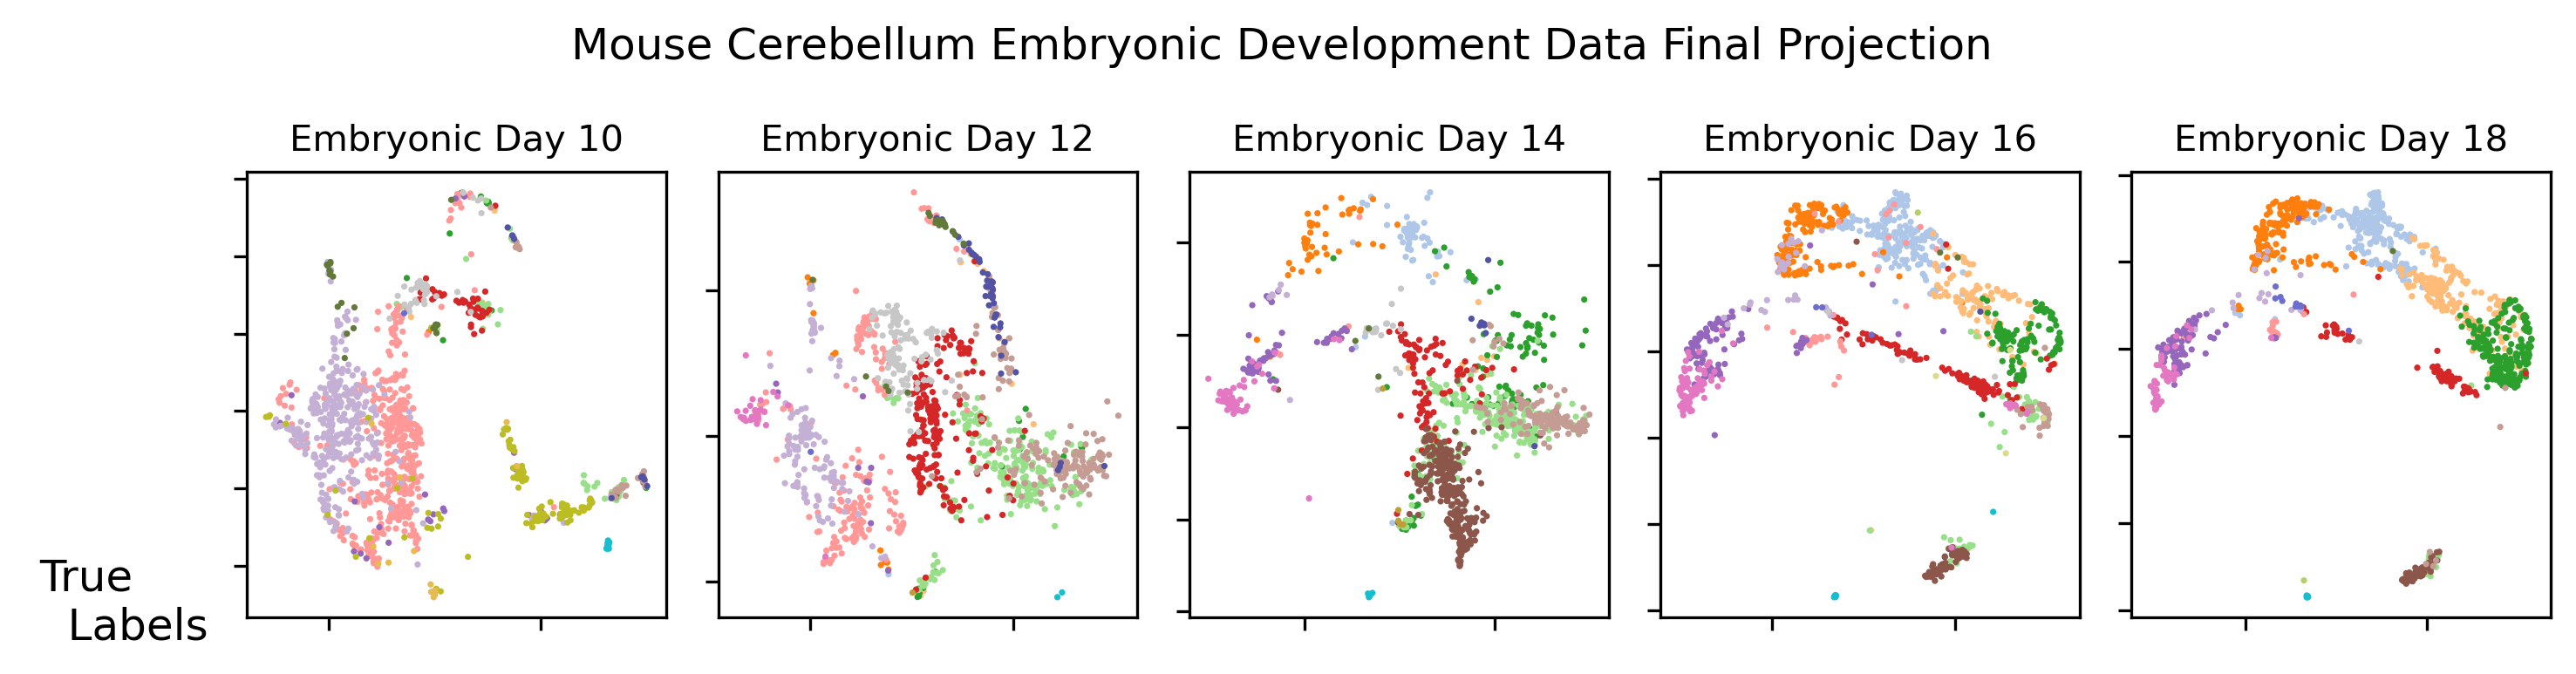

In [42]:
## Plot Mouse Cerebellum Really Nice
save = False
projection = 'Final' #'Standard' or 'Final'
method = 0 #0,1,2

import matplotlib.gridspec as gridspec
dim = [2,5]
lenPerSection = 9
if method==0:
    fig = plt.figure(figsize=(2*dim[1], 2*dim[0]+0.4), dpi=300)
else:
    fig = plt.figure(figsize=(2*dim[1], 2*dim[0]), dpi=300)
gs = gridspec.GridSpec(2, 10)

if method==0:
    fig.suptitle(f'Mouse Cerebellum Embryonic Development Data {projection} Projection')
ytitles = ['\n True\n   Labels', '\n GMM\n   Labels', '\nLouvain\n   Labels']
fig.supylabel(ytitles[method], rotation='horizontal')

titles = ['Embryonic Day 10', 'Embryonic Day 12', 'Embryonic Day 14', 'Embryonic Day 16', 'Embryonic Day 18',
          'Post-Natal Day 0', 'Post-Natal Day 5', 'Post-Natal Day 7', 'Post_Natal Day 14']

for i in range(0, 9):
    ytitle=None
    if i < 5:
        if i==0: ytitle = ytitles[0]
        ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
    else:
        if i==5: ytitle = ytitles[1]
        ax = plt.subplot(gs[1, 2 * i - 9:2 * i + 2 - 9])
    draw.tinyumap(drawData[i+method*lenPerSection], drawLabels[i+method*lenPerSection], title=titles[i])

plt.tight_layout()
methodNames = ['True', 'GMM', 'Louvain']
if save:
    fig.savefig(f"MouseCerebellum{projection}Clust{methodNames[method]}.png") 
plt.show()

\###### Baseline
u= UMAP(n_components=2)
u.fit(np.vstack(Data.data))
pdata = [u.transform(a) for a in Data.data]

#pdata = [UMAP().fit_transform(a) for a in Data.data]

labels = cluster.gmm_1(pdata[0], nc=30)
labels, e, labels, probas = k2means.multitunnelclust(list(pdata), labels, method='full')


draw.auto_tiny(pdata, labels, wrap='test', dim=dim)

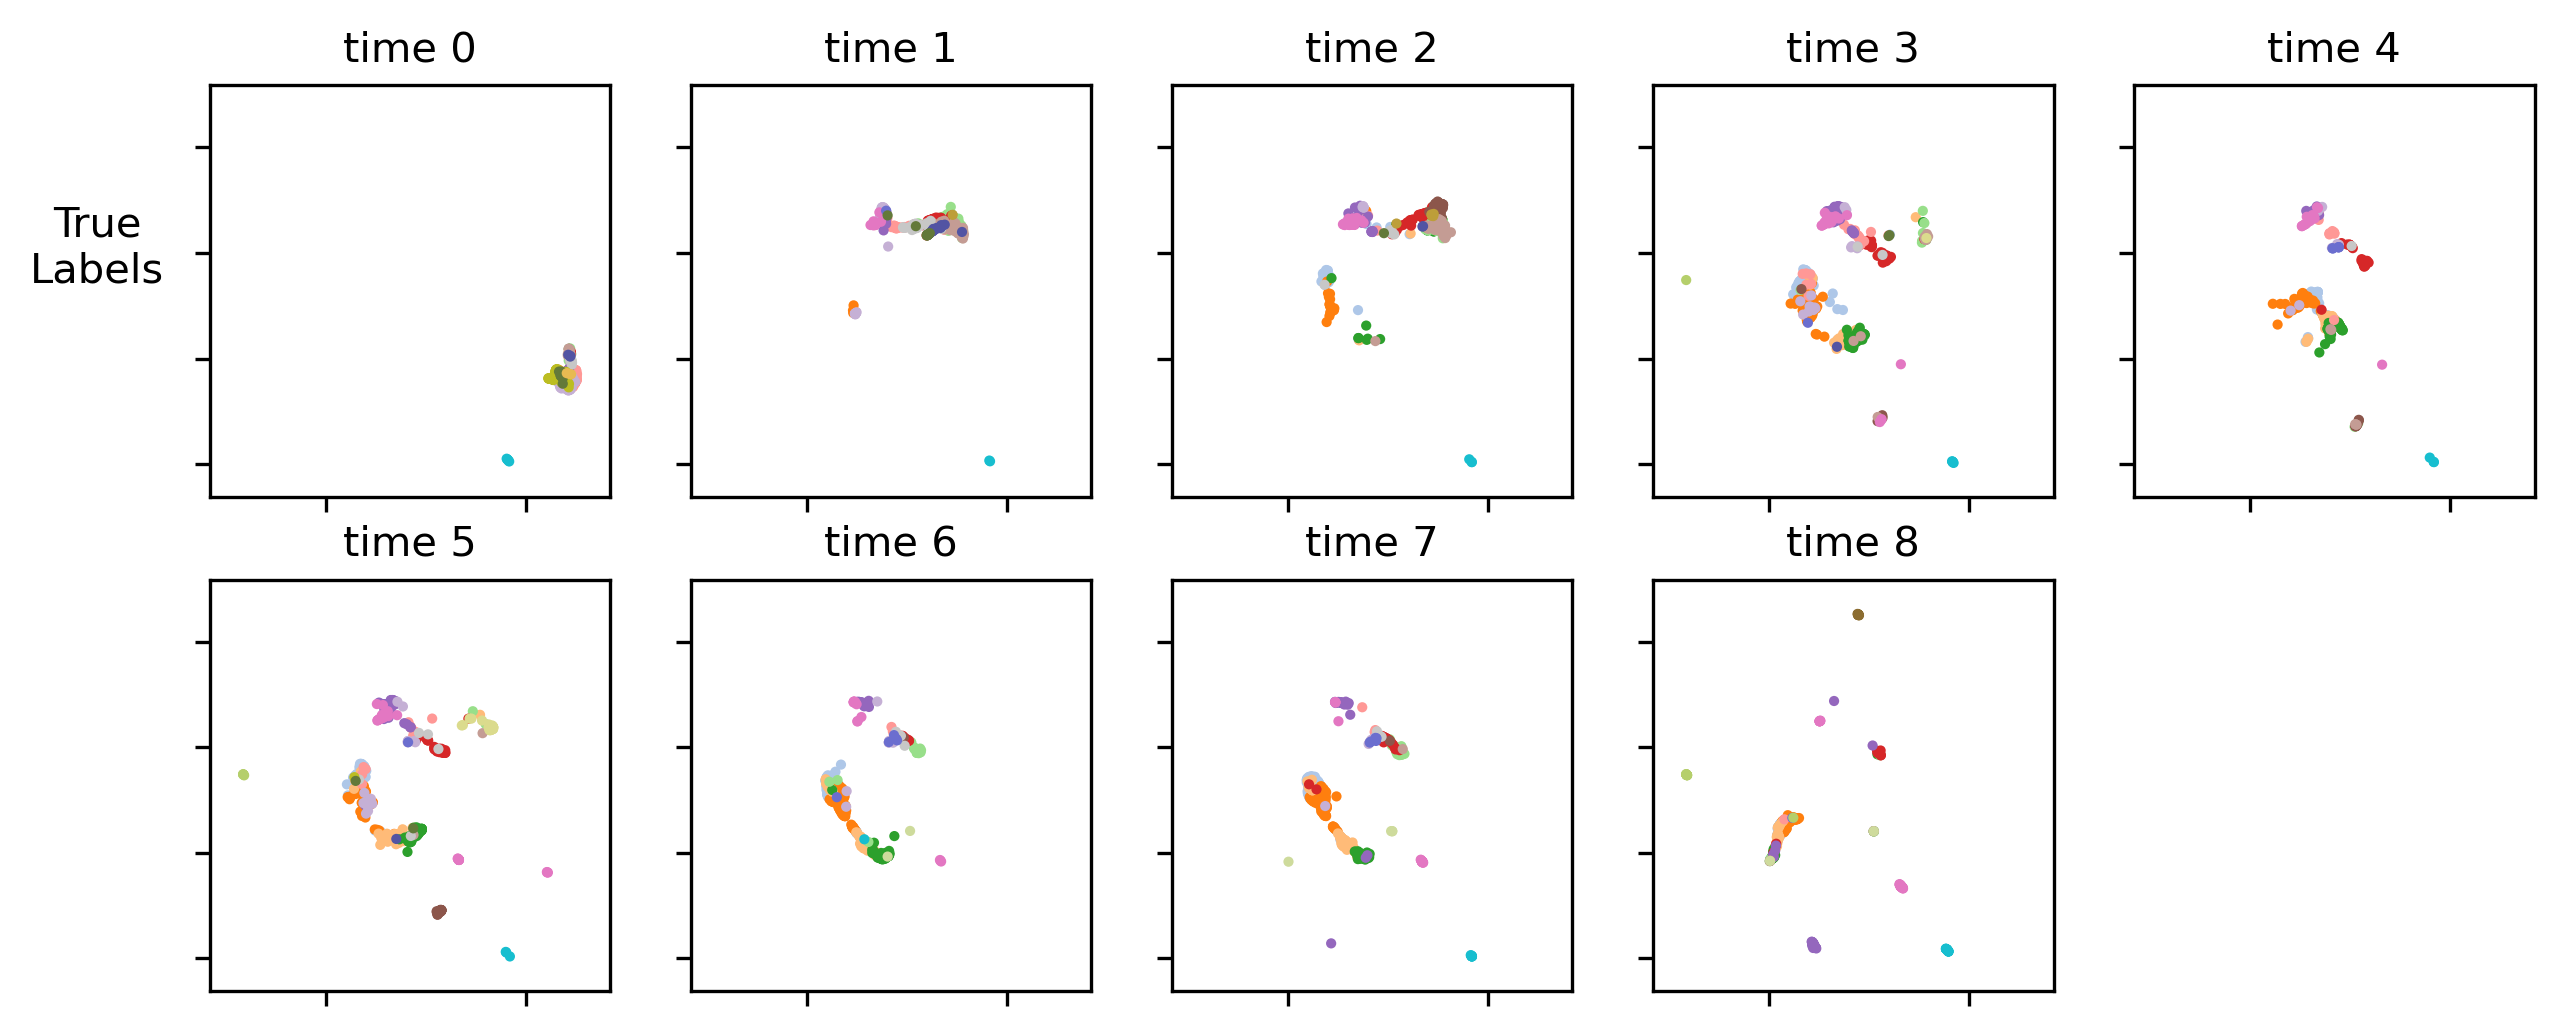

In [43]:
dim=(2,5)
xtitles = [f'time {t}' for t in range(dim[1])]
ytitles = ['\nTrue\nLabels']#, '\nGMM\nLabels', '\nLouvain\nLabels']
xtitles=[f'time {t}' for t in range(9)]
ytitles=['\nTrue\nLabels','']
draw.auto_tiny(drawData[:9], drawLabels[:9], wrap='test', dim=dim, same_limit=True, xtitles=xtitles, ytitles=ytitles, titleAll=True, legend=False, save=False, save_name=f'distCoeff{distCoeff}.png')

In [91]:
importlib.reload(differentiate)
importlib.reload(draw)
#importlib.reload(hungutil)

<module 'natto.out.draw' from '/Users/JackBrons/Freiburg_Sem4/Research Project/nattoWork/natto/natto/out/draw.py'>

Clusering Data 3
Counter({3: 293, 0: 210, 5: 143, 2: 73, 4: 72, 1: 72})
Best cluster is 6


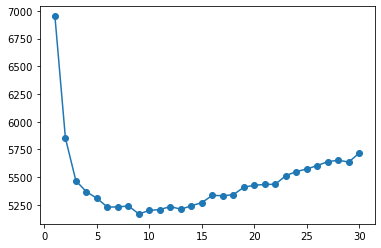

Best Number of Clusters for slice 3 is 6

Clusering Data 2


KeyboardInterrupt: 

In [112]:
from natto.process import differentiate
tempData2 = [x.copy() for x in transformedData]

time0 = time.time()
debug=True
max_components = 30
minClusters = 1
minClusterSize = 1
requireLessClusters = False
optMethod = 'uber' #'kneed', 'uber', 'BIC', 'uberBIC', AdjBIC', 'AIC', 'uberAIC'
BICPenalty = 1
gmmMethod = 'full'
labelsXD, labelPairsXD = differentiate.cellDifferentiationPipeline(tempData2, 
                                                                   max_components=max_components,
                                                                   minClusters=minClusters,
                                                                   minClusterSize=minClusterSize,
                                                                   optMethod=optMethod, 
                                                                   gmmMethod=gmmMethod, 
                                                                   plotOpt=True,
                                                                   plotIntermediateTiny=False,
                                                                   requireLessClusters=requireLessClusters,
                                                                   BICPenalty=BICPenalty,
                                                                   title='Sim5 Gene Expression Profiles',
                                                                   debug=debug)

print(f"Finished {time.time()-time0}s")

In [111]:
differentiate.getCanvases(tempData2, max_components=35, 
    minClusters=1, 
    minClusterSize=1, 
    optMethod='uber', 
    gmmMethod='full',
    requireLessClusters=False,
    BICPenalty=np.e,
    title=None,
    save='Sim5_confusion_Time')

NameError: name 'differentiate' is not defined

In [ ]:
for l in labelPairsXD:
    print(l)
### Calc ARI for these labels
for index, l in enumerate(Labels):
    print(f"ARI:{index} {ARI(tempLabels[index], labelsXD[index])}")
print(f"Overall ARI: {ARI(stackedLabels, [item for sublist in labelsXD for item in sublist])}")

def clusterTrace(data, labels, labelPairs, targets):
    dataToShow=[]
    labelsToShow =[]
    data = [np.asarray(d) for d in data]
    labels = [np.asarray(l) for l in labels]
    if type(targets)!=list:
        targets = [targets]
    if targets[0] in labelPairs[0].keys():
        clusterCentres = getClusterCentres2(labels, data)
        for i,l in enumerate(labelPairs):
            dataToShow, labelsToShow = getDrawStuff(data[i], labels[i], dataToShow, labelsToShow, targets)
            plt.scatter(dataToShow[-1][:,0], dataToShow[-1][:,1], c=labelsToShow[-1], cmap='tab20')#, c=np.unique(labelsToShow[-1]))
            plotArrows2(clusterCentres[i], clusterCentres[i+1], labelPairs[i], targets)
            plt.show()

            targets = [item for t in targets for item in l[t]]
            
        dataToShow, labelsToShow = getDrawStuff(data[-1], labels[-1], dataToShow, labelsToShow, targets)
        plt.scatter(dataToShow[-1][:,0], dataToShow[-1][:,1], c=labelsToShow[-1], cmap='tab20')
        plt.show()
    
    labelsToShow = differentiate.prelimAlign(labelsToShow, dataToShow)
    labelsMatchList, simMatrices, xyLabs = differentiate.clusterMatch(labelsToShow, dataToShow, threshold=0.5, plotIntermediateTiny=False)
    labelsToShow, labelPairsTemp = differentiate.adjustLabels(labelsToShow, labelsMatchList, simMatrices, xyLabs, debug=debug)
    labelsToShow, labelPairsTemp = differentiate.reduceLabels(labelsToShow, labelPairsTemp)
    
    draw.auto_tiny(dataToShow, labelsToShow, wrap='test', dim=(1,len(dataToShow)), same_limit=True)
    
def getDrawStuff(data, labels, dataToShow, labelsToShow, targets):
    mask = [i for i,label in enumerate(labels) for t in targets  if label==t]
    dataToShow.append(data[mask])
    labelsToShow.append(labels[mask])
    return dataToShow, labelsToShow

def getClusterCentres2(labels, data):
    ### Find centres of each cluster
    clusterCentres = [{} for i in range(len(labels))]
    for i, (l,d) in enumerate(zip(labels, data)):
        for n in np.unique(l):
            dMean = np.mean(d[np.where(l==n)[0]], axis=0)
            clusterCentres[i][n]=list(dMean)
    return clusterCentres

def plotArrows2(clusterCentres1, clusterCentres2, pairs, targets):
        d1=clusterCentres1
        d2=clusterCentres2
        for t in targets:
            print(f"{t} to:")
            for v in pairs[t]:
                print(v)
                plt.arrow(d1[t][0], d2[v][1], d2[v][0]-d1[t][0], d2[v][1]-d1[t][1], length_includes_head=True,
                  head_width=0.2, head_length=0.3, color='black')

     

whichCluster = 2
clusterTrace(tempData, labelsXD, labelPairsXD, whichCluster)
    